https://www.kaggle.com/maartenvandevelde/london-bike-share-prophet-xgb-lstm#-7.-LSTM-Modelling

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from keras import metrics
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
from matplotlib import style
style.use('ggplot')
plt.rcParams['font.family'] = "serif"
plt.rcParams.update({'font.size': 12})

rcParams['figure.figsize'] = 10, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
df = pd.read_csv('Final Data updated.csv', parse_dates=['Date'],index_col='Date')

In [ ]:
df.head()

,Demand,temp,rhum,wdsp,sun
Date,,,,,
2017-01-01 00:00:00,2890.0,5.3,91,12,0.0
2017-01-01 01:00:00,2658.5,4.9,95,8,0.0
2017-01-01 02:00:00,2488.0,5.0,92,8,0.0
2017-01-01 03:00:00,2320.0,4.2,90,12,0.0
2017-01-01 04:00:00,2221.5,3.6,88,11,0.0


In [ ]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [ ]:
df.head()

,Demand,temp,rhum,wdsp,sun,hour,day_of_month,day_of_week,month
Date,,,,,,,,,
2017-01-01 00:00:00,2890.0,5.3,91,12,0.0,0,1,6,1
2017-01-01 01:00:00,2658.5,4.9,95,8,0.0,1,1,6,1
2017-01-01 02:00:00,2488.0,5.0,92,8,0.0,2,1,6,1
2017-01-01 03:00:00,2320.0,4.2,90,12,0.0,3,1,6,1
2017-01-01 04:00:00,2221.5,3.6,88,11,0.0,4,1,6,1


Text(0.5, 1.0, 'Hourly Electricity Demand')

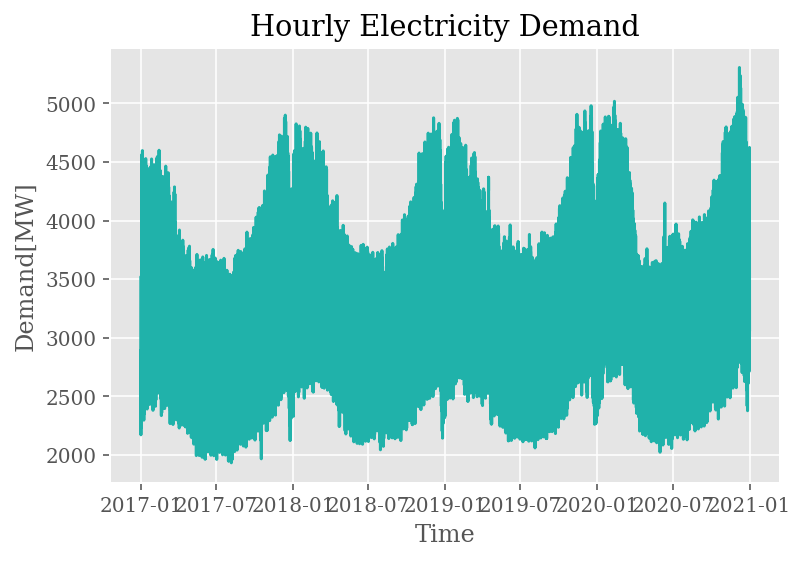

In [ ]:
from matplotlib import style
style.use('ggplot')
plt.rcParams['font.family'] = "serif"

sns.lineplot(x=df.index,y='Demand',data=df,color='lightseagreen')

plt.xlabel("Time")
plt.ylabel("Demand[MW]")
plt.title('Hourly Electricity Demand')

Text(0.5, 1.0, 'Monthly Electricity Demand')

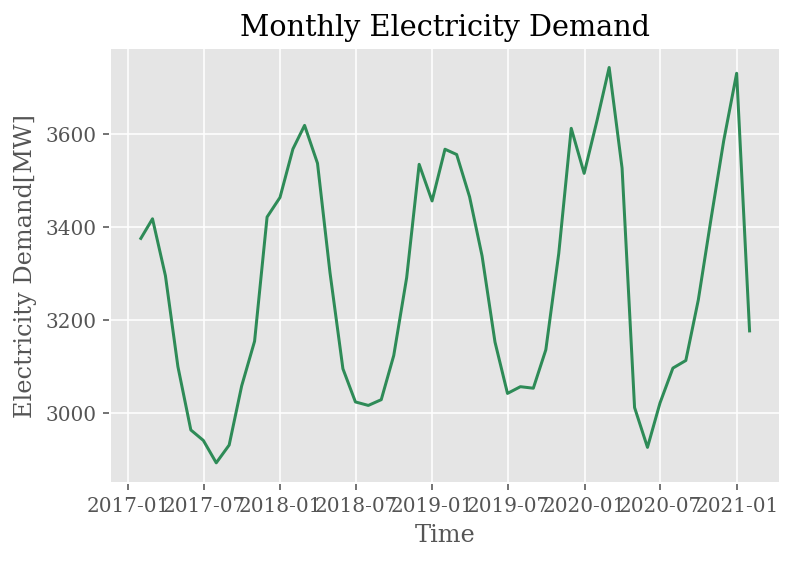

In [ ]:
df_monthly=df.resample('M').mean()
sns.lineplot(x=df_monthly.index,y='Demand', data=df_monthly,color='seagreen')
plt.xlabel("Time")
plt.ylabel("Electricity Demand[MW]")
plt.title('Monthly Electricity Demand')

Text(0.5, 1.0, 'Hourly Electricity Demand')

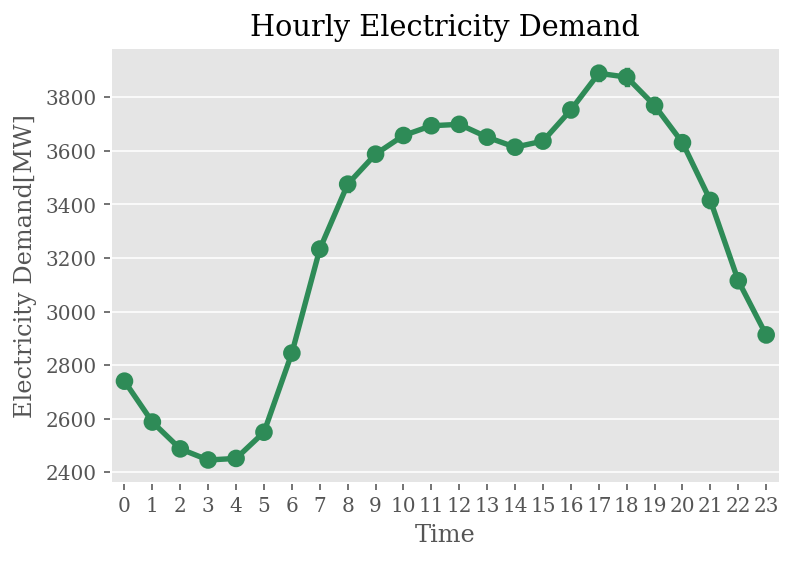

In [ ]:
sns.pointplot(x='hour', y='Demand',data=df,color='seagreen')
plt.xlabel("Time")
plt.ylabel("Electricity Demand[MW]")
plt.title('Hourly Electricity Demand')

Text(0.5, 1.0, 'Daily Electricity Demand')

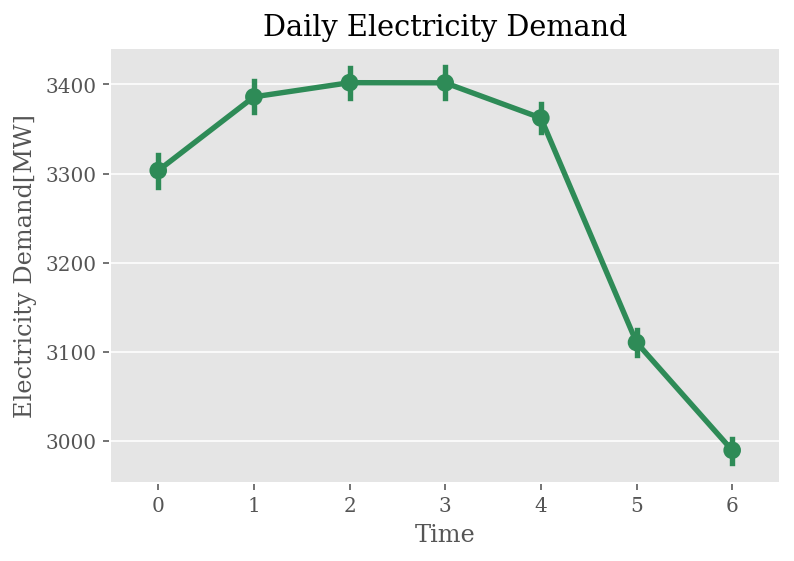

In [ ]:
sns.pointplot(x='day_of_week', y='Demand',data=df,color='seagreen')
plt.xlabel("Time")
plt.ylabel("Electricity Demand[MW]")
plt.title('Daily Electricity Demand')

In [ ]:
train_size = int(len(df) * 0.9)  #for90/10
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(31559, 9) (3507, 9)


In [ ]:
from sklearn.preprocessing import RobustScaler
f_columns = ['temp', 'rhum', 'wdsp', 'sun']

f_transformer = RobustScaler()
demand_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
demand_transformer = demand_transformer.fit(train[['Demand']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Demand'] = demand_transformer.transform(train[['Demand']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Demand'] = demand_transformer.transform(test[['Demand']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 24 #10

X_train, y_train = create_dataset(train, train.Demand, time_steps)
X_test, y_test = create_dataset(test, test.Demand, time_steps)

print(X_train.shape, y_train.shape)

(31535, 24, 9) (31535,)


In [ ]:
print(X_test.shape, y_test.shape)

(3483, 24, 9) (3483,)


In [ ]:
X_train[0][0].shape

(9,)

In [ ]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [ ]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(24,9)# 10,9
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))#it was 1
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mse', 'mae', 'mape','msle','RootMeanSquaredError'])

In [ ]:
history = model.fit (X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.1,   #0.1 for 90/10 ratio
                    shuffle=False
                    ) #adjust validation according to test train size

Epoch 1/30
887/887 [==============================] - 48s 48ms/step - loss: 0.1686 - mse: 0.1686 - mae: 0.2901 - mape: 20959.2617 - msle: 0.0327 - root_mean_squared_error: 0.4106 - val_loss: 0.0780 - val_mse: 0.0780 - val_mae: 0.2178 - val_mape: 127304.5859 - val_msle: 0.0180 - val_root_mean_squared_error: 0.2792
Epoch 2/30
887/887 [==============================] - 47s 53ms/step - loss: 0.0438 - mse: 0.0438 - mae: 0.1609 - mape: 17435.2422 - msle: 0.0104 - root_mean_squared_error: 0.2092 - val_loss: 0.0253 - val_mse: 0.0253 - val_mae: 0.1205 - val_mape: 47023.5859 - val_msle: 0.0061 - val_root_mean_squared_error: 0.1591
Epoch 3/30
887/887 [==============================] - 41s 46ms/step - loss: 0.0255 - mse: 0.0255 - mae: 0.1221 - mape: 14782.9229 - msle: 0.0059 - root_mean_squared_error: 0.1597 - val_loss: 0.0336 - val_mse: 0.0336 - val_mae: 0.1456 - val_mape: 69882.4688 - val_msle: 0.0076 - val_root_mean_squared_error: 0.1833
Epoch 4/30
887/887 [==============================] - 43s

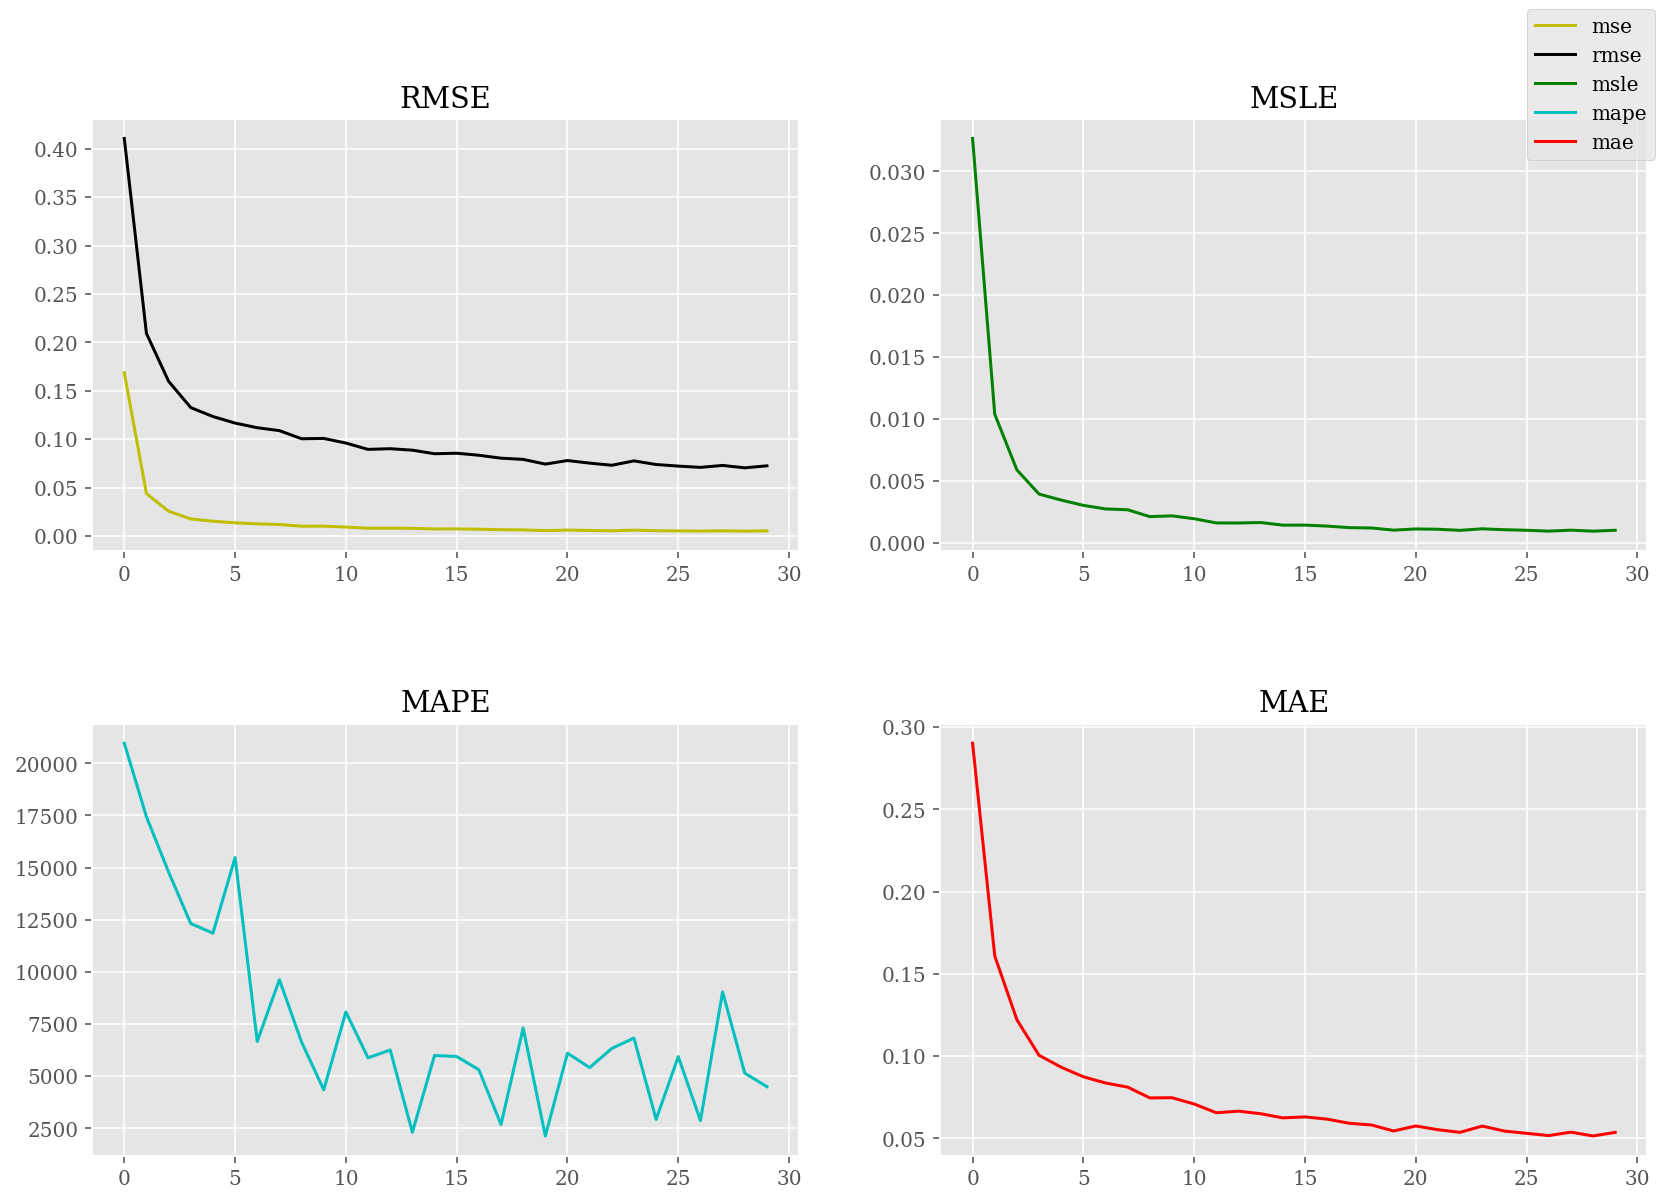

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].plot(history.epoch,history.history['mse'],'y',label='mse')
axs[0,0].set_title('MSE/RMSE')
axs[0,0].set_label('mse')
axs[0,0].plot(history.epoch,history.history['root_mean_squared_error'],'k',label='rmse')
axs[0,0].set_title('RMSE')

axs[0,1].plot(history.epoch,history.history['msle'],'g',label='msle')
axs[0,1].set_title('MSLE')
axs[0,1].set_label('msle')
axs[1,1].plot(history.epoch,history.history['mae'],'r',label='mae')
axs[1,1].set_title('MAE')

axs[1,0].plot(history.epoch,history.history['mape'],'c',label='mape')
axs[1,0].set_title('MAPE')


"""axs[0,0].set_ylabel('Error')   #do this for all axs[] combo
axs[0,2].set_ylabel('Error')
axs[0,0].set_xlabel('Epoch')
axs[0,2].set_xlabel('Epoch')
axs[0,0].legend()
axs[0,2].legend()"""
fig.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0, 
                    right=1, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.4)


#plt.savefig('blah.pdf')

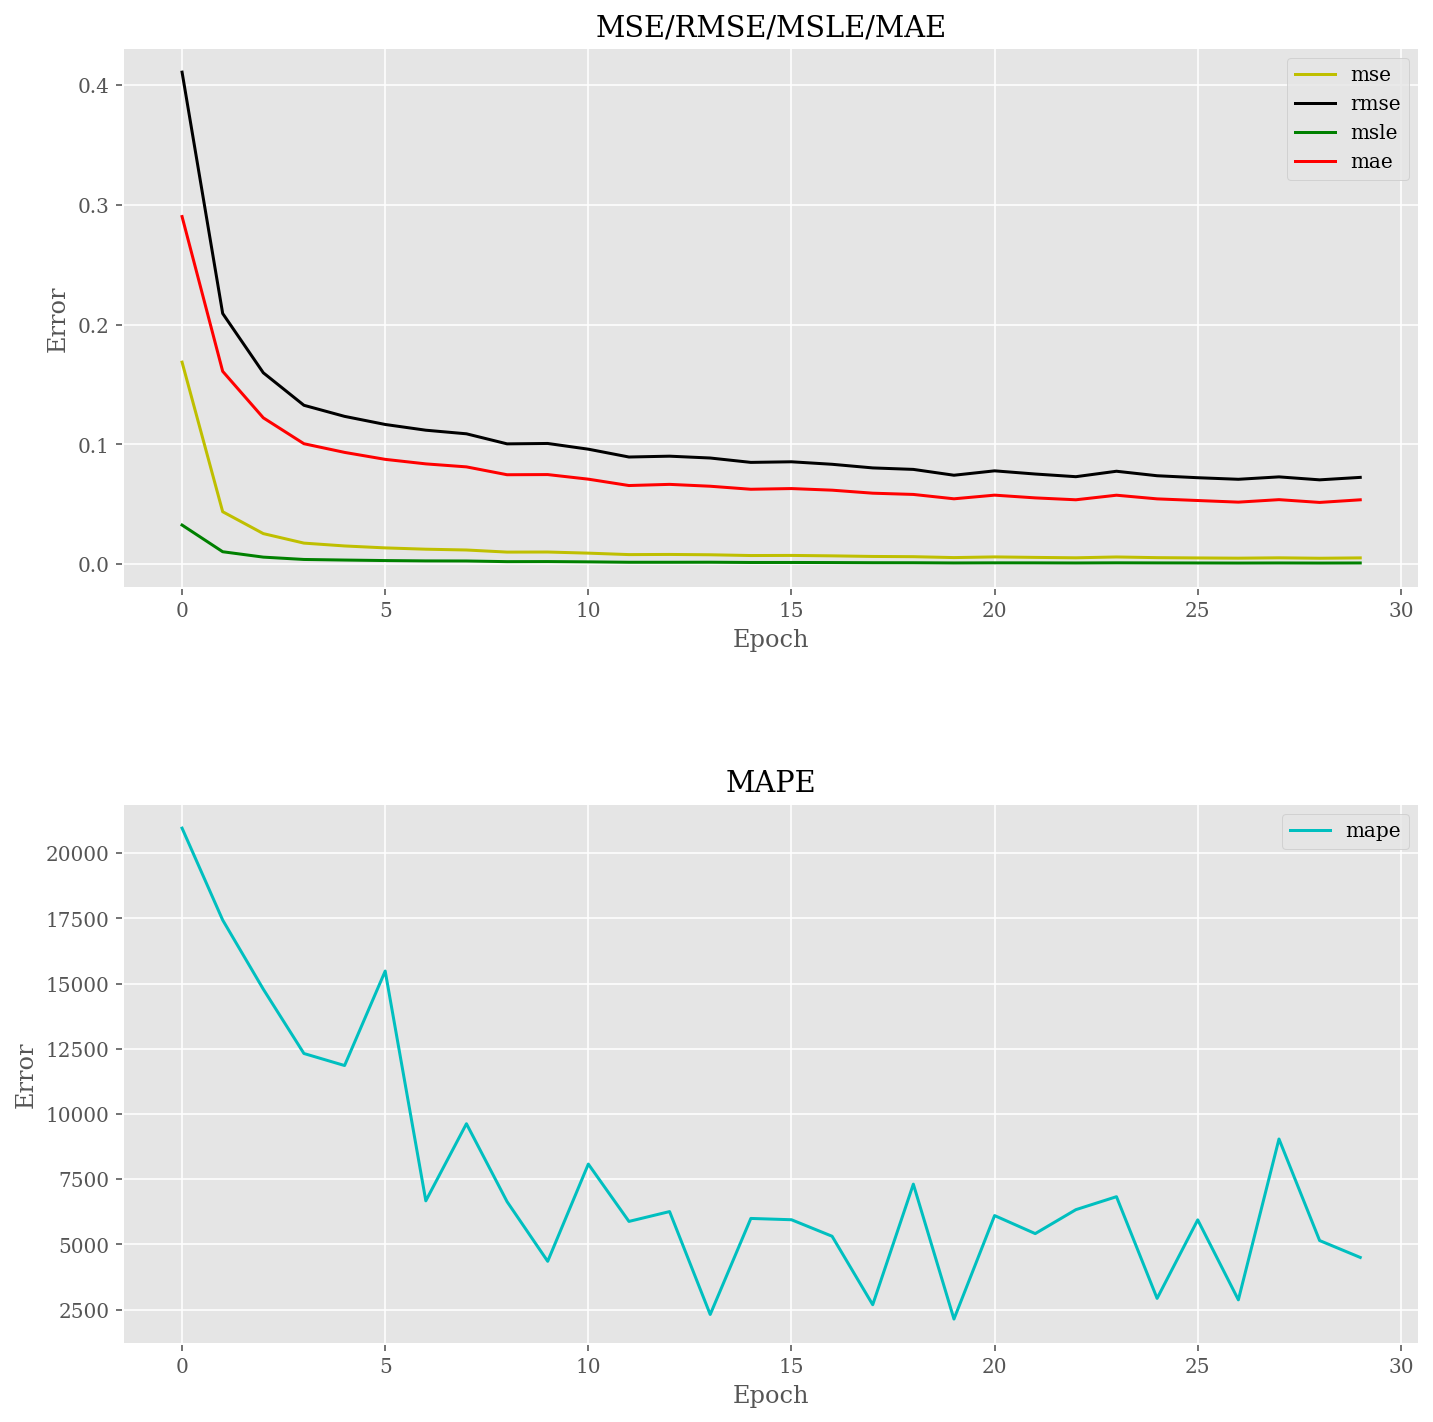

In [ ]:
#when 1,2 or 2,1 sub plots are selected location vectors are can only be one dimensional so not 0,1 just 0 or 1

fig, axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(history.epoch,history.history['mse'],'y',label='mse')
axs[0].set_title('MSE/RMSE/MSLE/MAE')
axs[0].set_label('mse')
axs[0].plot(history.epoch,history.history['root_mean_squared_error'],'k',label='rmse')
axs[0].set_label('RMSE')
axs[0].plot(history.epoch,history.history['msle'],'g',label='msle')
axs[0].set_label('msle')
axs[1].plot(history.epoch,history.history['mape'],'c',label='mape')
axs[1].set_title('MAPE')
axs[0].plot(history.epoch,history.history['mae'],'r',label='mae')

axs[0].set_ylabel('Error')
axs[1].set_ylabel('Error')
axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')
axs[0].legend()
axs[1].legend()
plt.subplots_adjust(left=0.1,
                    bottom=0, 
                    right=1, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0.4)
rcParams.update({'figure.autolayout': True})
plt.savefig('lstmMetrics.pdf')

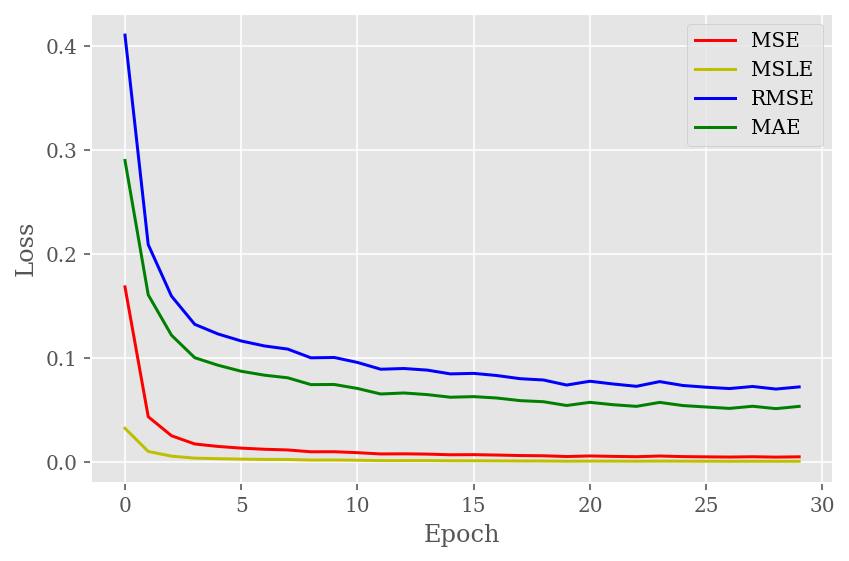

In [ ]:
plt.plot(history.history['mse'],'r',label='MSE')
plt.plot(history.history['msle'],'y',label='MSLE')
plt.plot(history.history['root_mean_squared_error'],'b',label='RMSE')
plt.plot(history.history['mae'],'g',label='MAE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

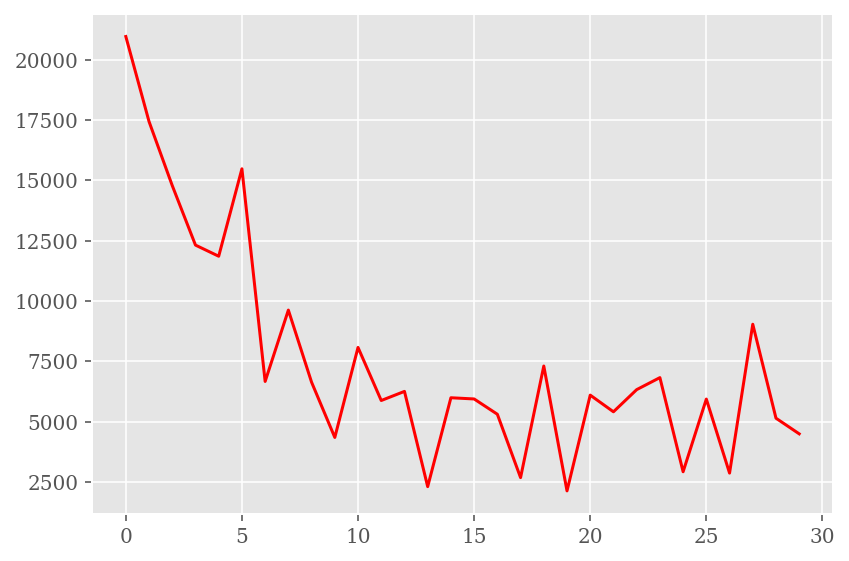

In [ ]:
plt.plot(history.history['mape'],'r',label='MAPE')

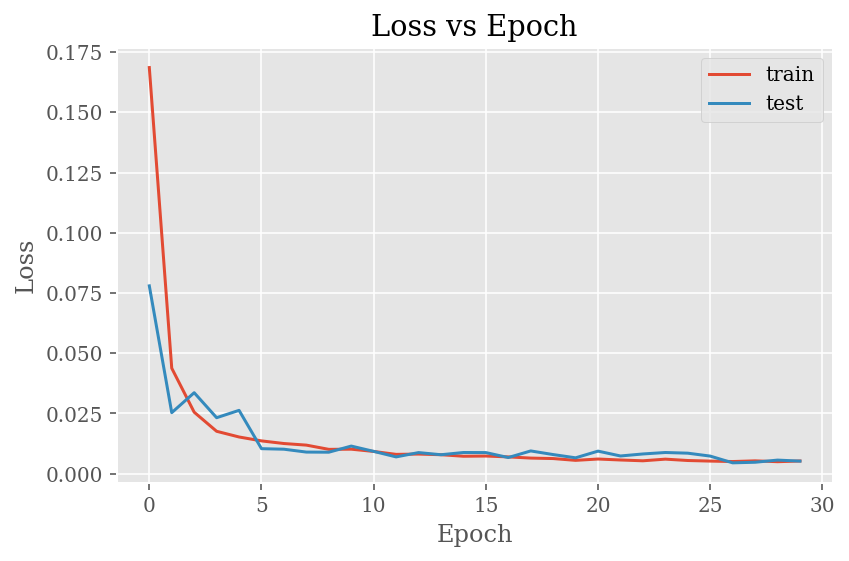

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs Epoch')
rcParams.update({'figure.autolayout': True})
plt.legend()
plt.savefig('LossvsEpoch.pdf')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error,mean_squared_log_error
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
mse_lstm=mean_squared_error(y_test, y_pred)
mape_lstm= mean_absolute_percentage_error(y_test, y_pred)
mae_lstm=mean_absolute_error(y_test,y_pred)
msle_lstm=mean_squared_log_error(np.absolute(y_test),np.absolute(y_pred))

print(rmse_lstm,mse_lstm,mae_lstm,msle_lstm)

0.08277133324787392 0.0068510936076305986 0.053717472982242304 0.0027964632425424617


In [ ]:
y_train_inv = demand_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = demand_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = demand_transformer.inverse_transform(y_pred)

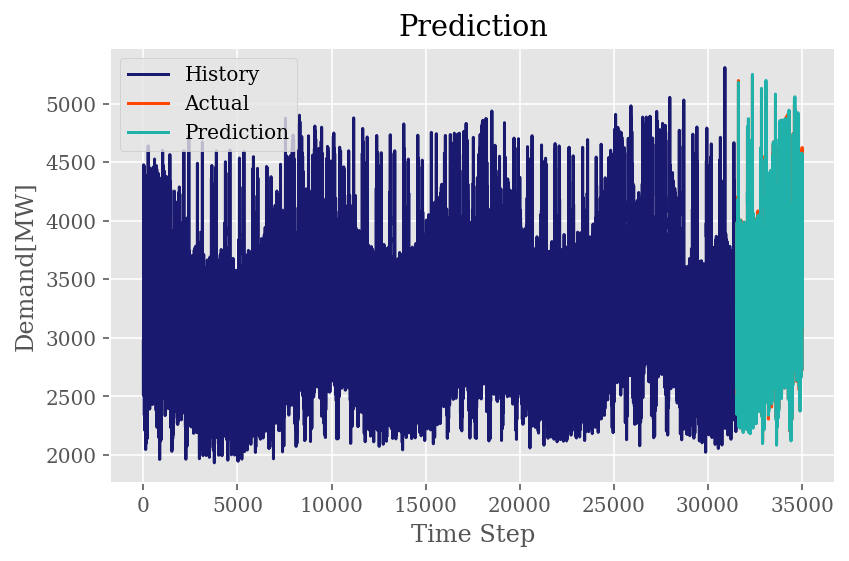

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'midnightblue', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(),color='orangered' ,label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(),color='lightseagreen' , label="Prediction")
plt.ylabel('Demand[MW]')
plt.title('Prediction')
plt.xlabel('Time Step')
plt.legend()

#rcParams.update({'figure.autolayout': True})

rcParams['figure.figsize'] = 12,8
plt.savefig('LSTMprediction9.pdf')
plt.show()

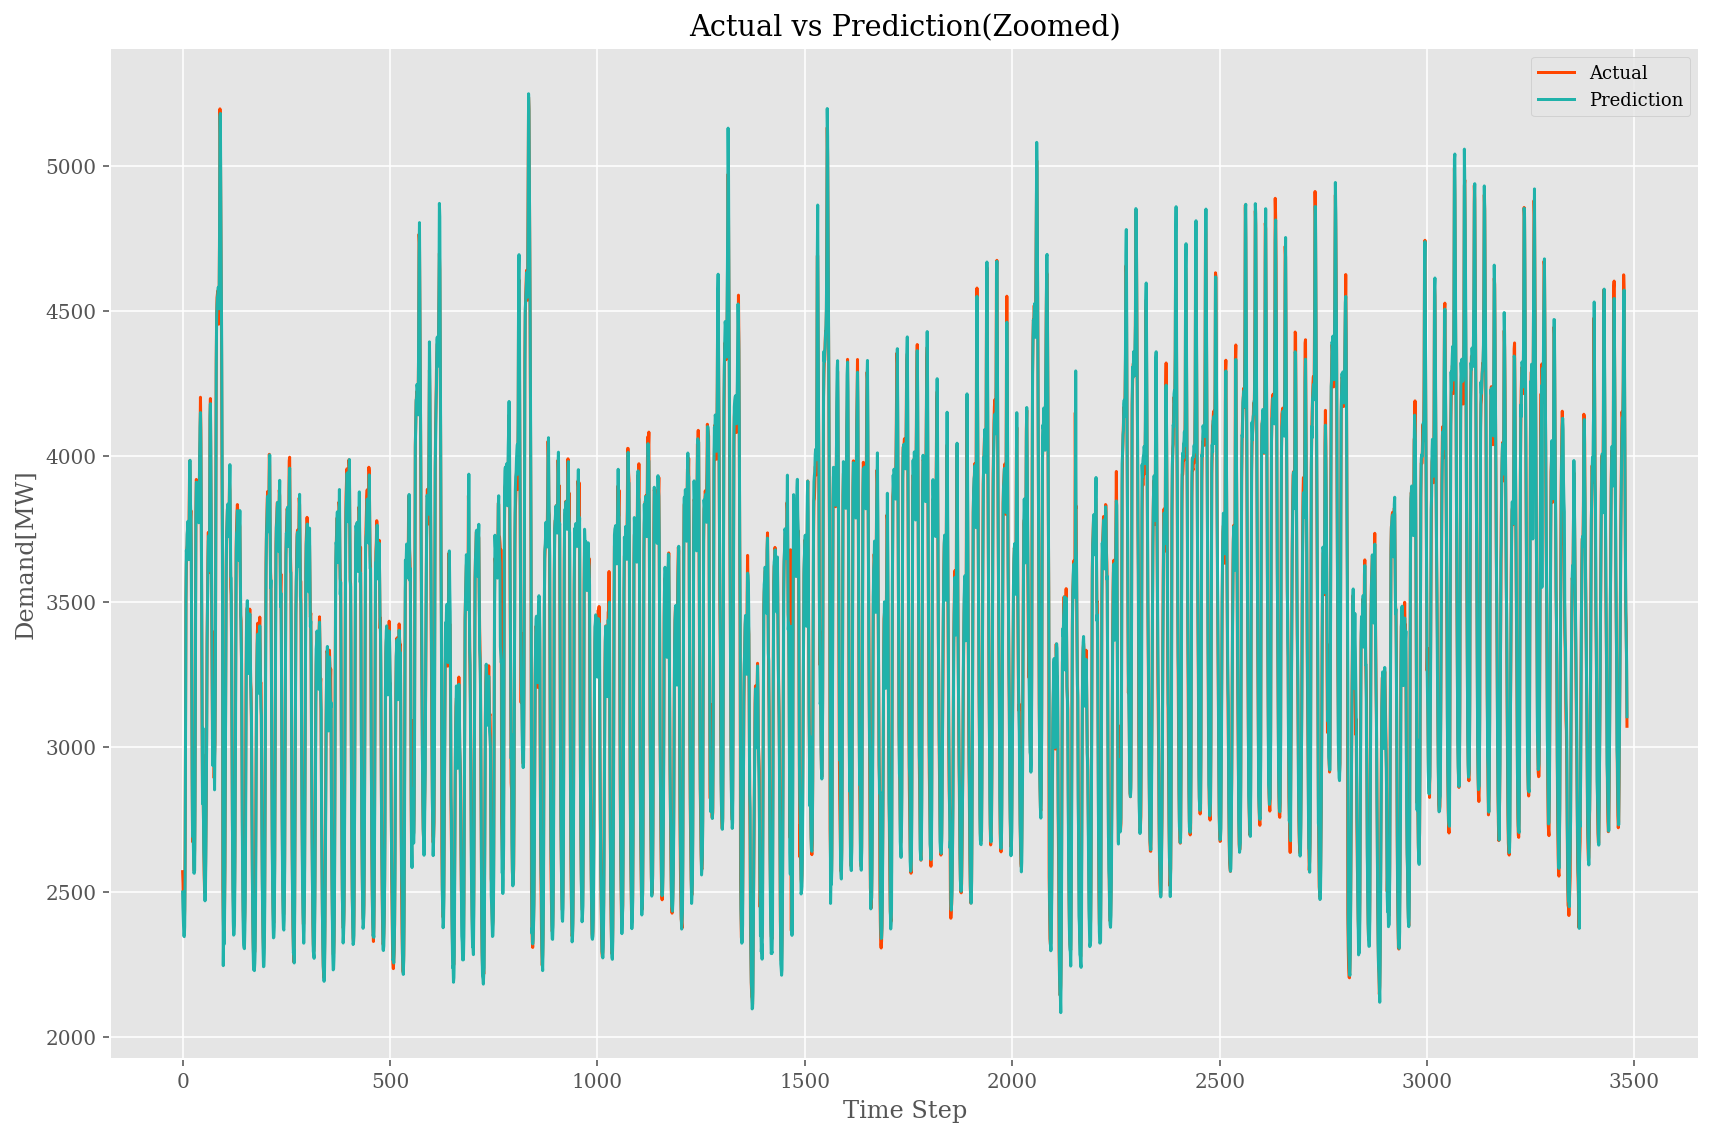

In [ ]:
plt.plot(y_test_inv.flatten(), color='orangered', label="Actual") #marker='.'
plt.plot(y_pred_inv.flatten(),color='lightseagreen' ,label="Prediction")
plt.title('Actual vs Prediction(Zoomed)')
plt.ylabel('Demand[MW]')
plt.xlabel('Time Step')
plt.legend()
plt.legend(loc = "upper right")
plt.legend(fontsize=9) 
#rcParams.update({'figure.autolayout': True})
#plt.savefig('LSTMpredictionzoomed.pdf')
#plt.show()

This graph can be used to prove predictions

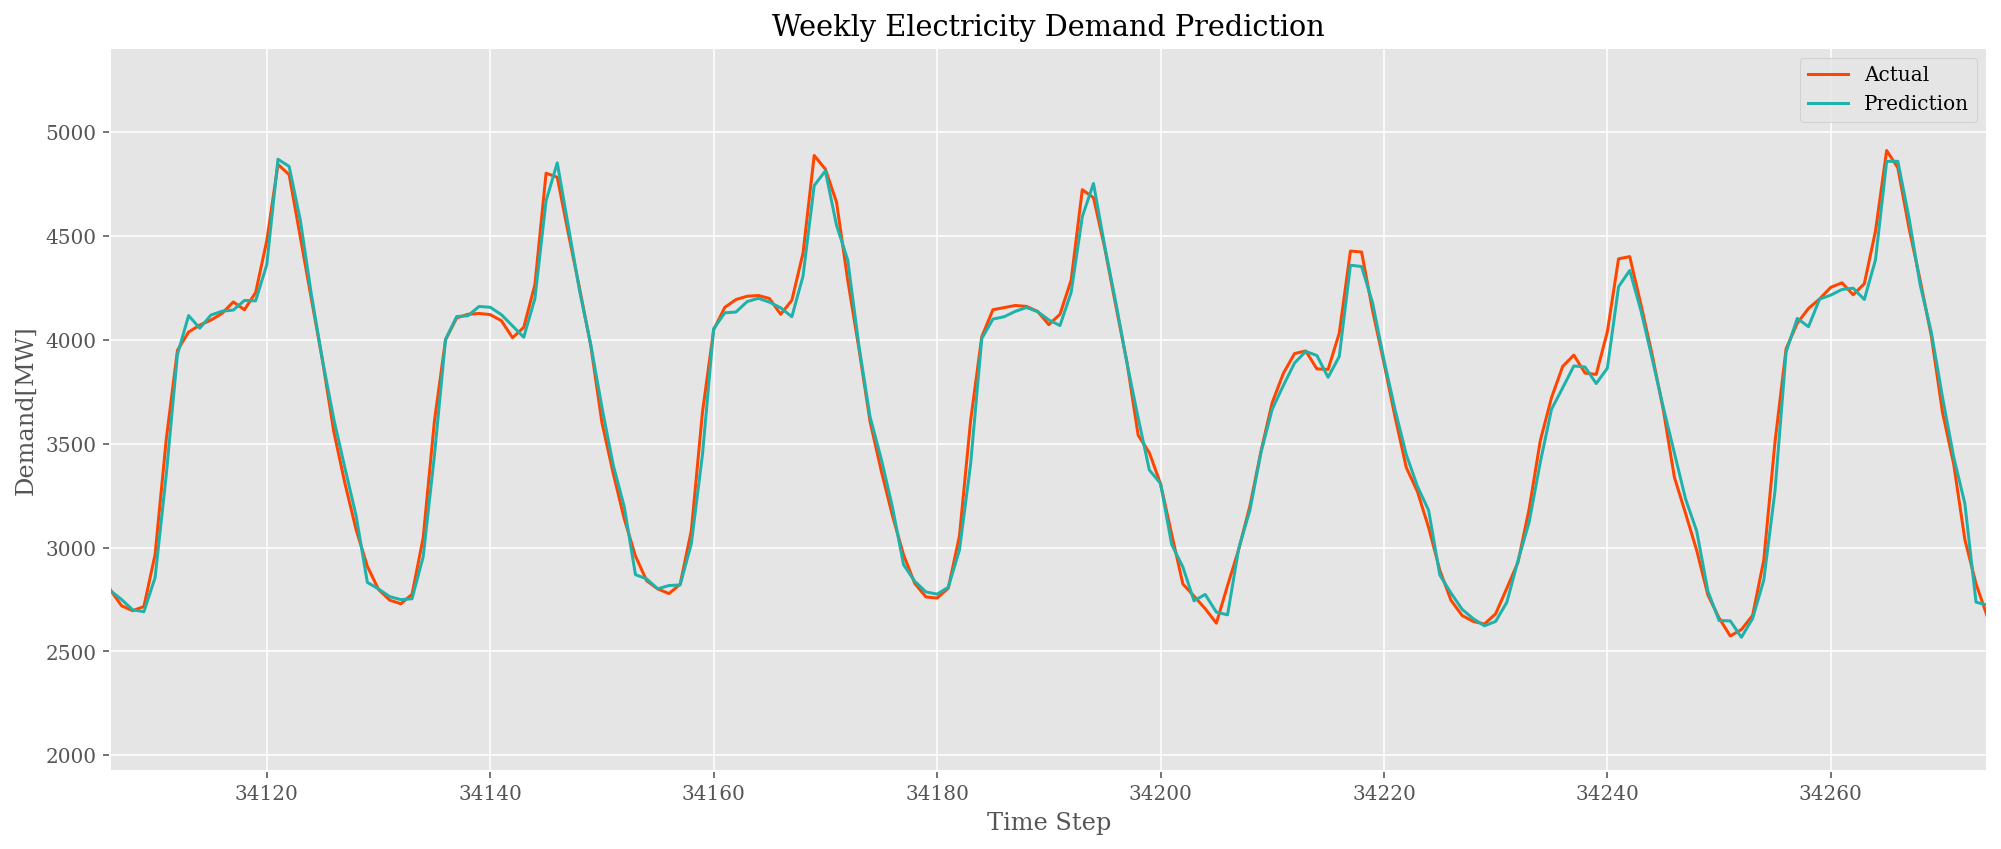

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = "serif"
rcParams['figure.figsize'] = 14, 6

palette=("Blues_d")

#plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'midnightblue', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(),color='orangered' ,label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(),color='lightseagreen' , label="Prediction",linewidth=1.5)

plt.ylabel('Demand[MW]')
plt.title('Weekly Electricity Demand Prediction')
plt.xlabel('Time Step')
plt.xlim(34106,34274)#22/11/2020-29/11/2020 sunday to sunday
#plt.xlim(22540,22705)
rcParams['figure.figsize'] = 13, 6
plt.legend()

plt.savefig('LSTMweekperiodfinal.pdf')
plt.show()